In [1]:
import numpy as np
import pandas as pd
import math

## Part 1. Data Preprocessing

In [2]:
df = pd.read_csv('AAPL_max.csv')
df = df.iloc[-math.ceil(len(df) * 0.3):] # only use last 30% of data
df.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
9961,2020-06-16,351.459991,353.200012,344.720001,352.079987,352.079987,41357200.0
9962,2020-06-17,355.149994,355.399994,351.089996,351.589996,351.589996,28532000.0
9963,2020-06-18,351.410004,353.450012,349.220001,351.730011,351.730011,24158600.0


In [3]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

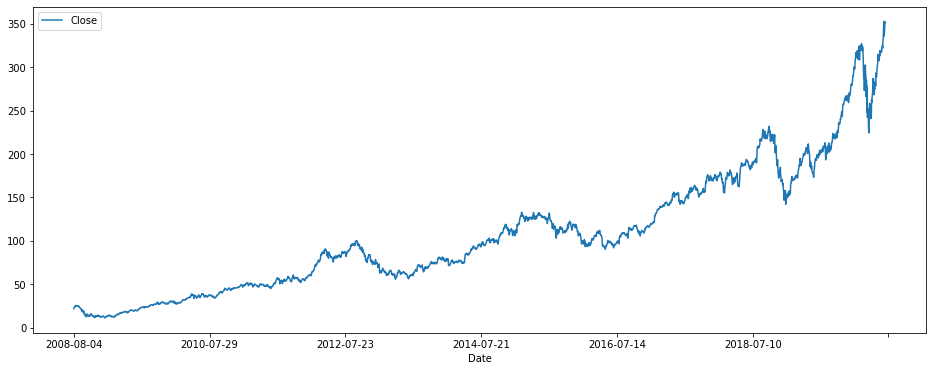

In [4]:
df.plot(x = 'Date', y = 'Close', figsize = (16, 6))

In [5]:
# use Close price for prediction
df = df['Close']

In [6]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
dataset = sc.fit_transform(pd.DataFrame(df).values)

## Part 2. Training

### Function definition for tuning

In [7]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

def train_pred_eval(dataset,
                    lags = 3, 
                    test_size = 0.2,
                    seed = 100,
                    n_estimators = 100,
                    max_depth = 3,
                    learning_rate = 0.1, 
                    min_child_weight = 1, 
                    subsample = 1,
                    colsample_bytree = 1,
                    colsample_bylevel = 1,
                    gamma = 0):    
    # use lags of data as features
    x, y = [], []
    for i in range(lags, len(dataset)):
        x.append(dataset[i-lags:i])
        y.append(dataset[i])
    x, y = np.array(x), np.array(y)

    # split
    train_size = len(x) - math.floor(len(x) * test_size)
    x_train, y_train = x[:train_size], y[:train_size]
    x_test, y_test = x[train_size:], y[train_size:]

    # reshape to reduce one dimension as expected input of XGBRegressor
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))

    # init XGB
    model = XGBRegressor(seed=seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)

    model.fit(x_train, y_train)
    
    # predict
    y_pred = model.predict(x_test)
    y_pred = sc.inverse_transform(y_pred)
    y_test = sc.inverse_transform(y_test)
    
    # eval
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse

In [8]:
import time
from tqdm.notebook import tqdm

error_rate = {'param': [], 'rmse': []}
params = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

# train, predict and evaluate
start_ts = time.time()
for param in tqdm(params):
    rmse = train_pred_eval(dataset,
                           lags = 3, 
                           test_size = 0.2,
                           seed = 100,
                           n_estimators = 40,
                           max_depth = 5,
                           learning_rate = param, 
                           min_child_weight = 2, 
                           subsample = 1,
                           colsample_bytree = 1,
                           colsample_bylevel = 1,
                           gamma = 0)
    error_rate['param'].append(param)
    error_rate['rmse'].append(rmse)
    
end_ts = time.time()
print(f'time elapsed: {(end_ts - start_ts)/60.0} mins')

[15:57:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:57:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:57:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:57:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:57:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:57:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:57:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

time elapsed: 0.009009345372517904 mins


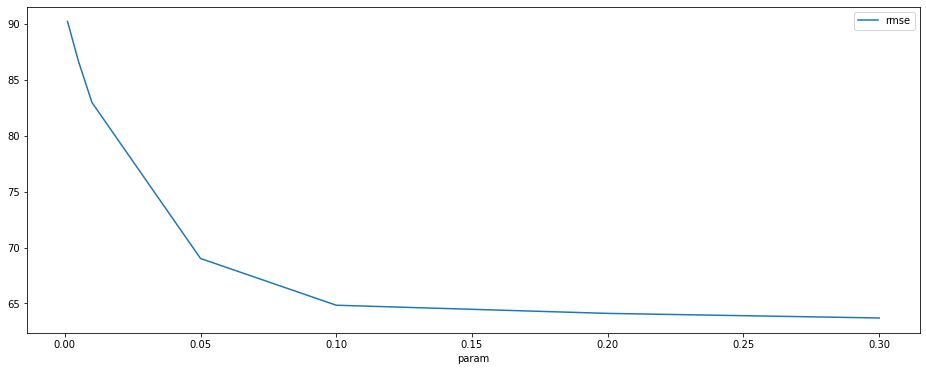

In [9]:
error_rate_df = pd.DataFrame(error_rate)
error_rate_df.plot(x = 'param', y = 'rmse', figsize = (16, 6))

In [10]:
error_rate_df

,param,rmse
0,0.001,90.216341
1,0.005,86.680041
2,0.010,82.971267
3,0.050,69.022860
4,0.100,64.843548
5,0.200,64.114186
6,0.300,63.704217
